In [13]:
import os
import shutil
import numpy as np
import pandas as pd
import pandas.io.sql as sqlio
from sqlalchemy import create_engine, text
from assistments.sdk.aws.manager import rds

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, r2_score


import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Masking, LSTM, Dense, Dropout, Concatenate

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

In [12]:
# Pull usage stats
# Constants
SCRIPT_DIR = 'assistments_data/sql'
OUT_DIR = 'assistments_data/csv'
TMP_DIR = 'assistments_data/sql/tmp'
DATA_SCRIPT = 'year_data_query.sql'
TMP_SCRIPT = 'tmp.sql'

# Create sql instance
manager = rds.Manager()
credentials = manager.get_db_credentials('rds-dev', 'tng')
url = f'postgresql://{credentials.username}:{credentials.password}@{credentials.host}:{credentials.port}/cas_core'
dev_engine = create_engine(url)
dev_conn = dev_engine.connect().execution_options(autocommit=True)

# Get school year data
school_year_data = []
for year in [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]:
    if os.path.exists(TMP_DIR):
        shutil.rmtree(TMP_DIR)
    os.makedirs(TMP_DIR)
    with open(f'{SCRIPT_DIR}/{DATA_SCRIPT}', 'rt') as fin:
        with open(f'{TMP_DIR}/{TMP_SCRIPT}', 'wt') as fout:
            for line in fin:
                fout.write(line.replace('START_YEAR', str(year)).replace('END_YEAR', str(year + 1)))
    data = sqlio.read_sql_query(text(open(f'{TMP_DIR}/{TMP_SCRIPT}', 'r').read()), dev_conn)
    os.remove(f'{TMP_DIR}/{TMP_SCRIPT}')
    data['school_start_year'] = year
    data['school_end_year'] = year + 1
    school_year_data.append(data)
    shutil.rmtree(TMP_DIR)
school_year_data = pd.concat(school_year_data, axis=0)

mass_doe_data = pd.read_pickle('mass_doe_data/clean_data.pkl')
middle_school_pop = mass_doe_data['Enrollment by Grade (2017-18)__School__6'].fillna(0) + \
                    mass_doe_data['Enrollment by Grade (2017-18)__School__7'].fillna(0) + \
                    mass_doe_data['Enrollment by Grade (2017-18)__School__8'].fillna(0)
middle_school_pop = middle_school_pop.rename('middle_school_pop').reset_index()
school_year_data = school_year_data.merge(middle_school_pop, how='inner', on='school_id')
school_year_data['a/s'] = school_year_data['assignment_log_count'] / school_year_data['middle_school_pop']


In [25]:
school_year_data.to_csv(f'{OUT_DIR}/school_year_data.csv', index=False)

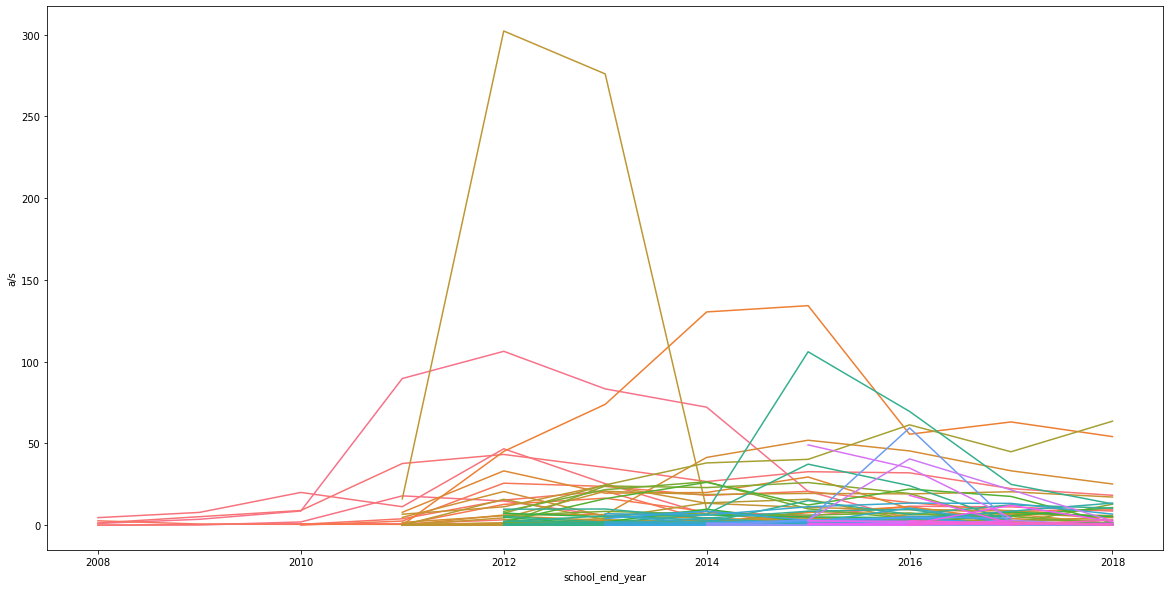

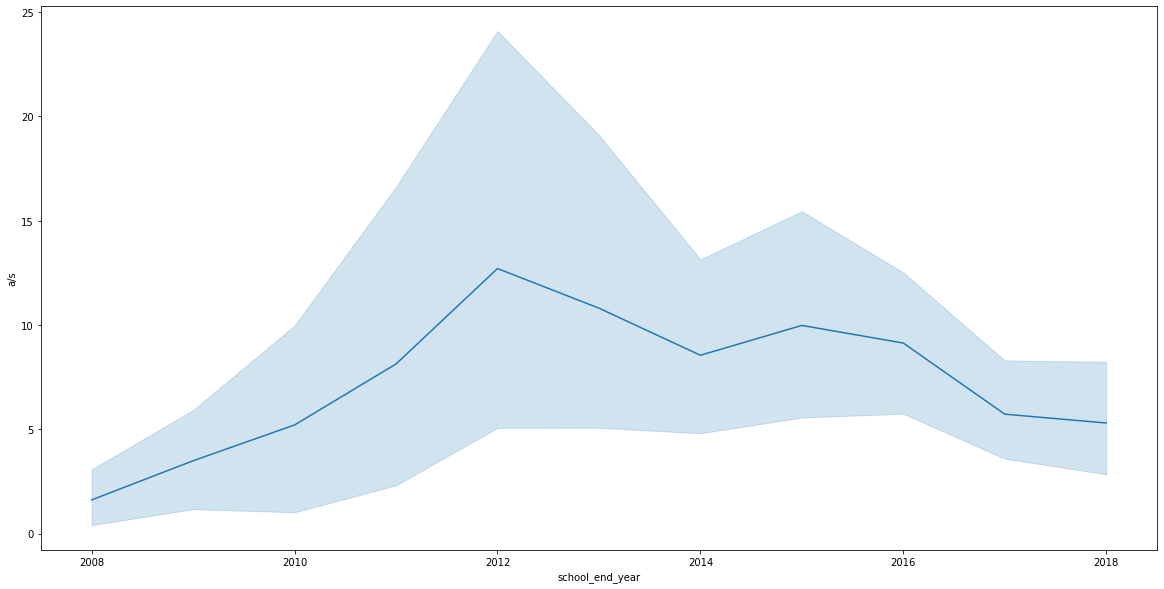

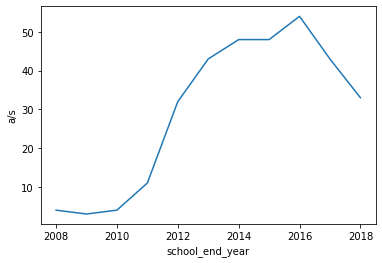

In [23]:
plt.figure(figsize=(20,10))
sns.lineplot(data=school_year_data, x='school_end_year', y='a/s', hue='school_id', legend=False)
plt.show()

plt.figure(figsize=(20,10))
sns.lineplot(data=school_year_data, x='school_end_year', y='a/s', legend=False)
plt.show()

agg_data = school_year_data.groupby('school_end_year')['a/s'].apply(lambda x: (x >= 1).sum()).reset_index()
plt.figure()
sns.lineplot(data=agg_data, x='school_end_year', y='a/s')
plt.show()

In [26]:
# Load the data
assistments_data = pd.read_csv('assistments_data/assistments_usage_data.csv', dtype='str')
mass_doe_data = pd.read_pickle('mass_doe_data/clean_data.pkl')

# Find qualified treatment schools
middle_school_pop = mass_doe_data['Enrollment by Grade (2017-18)__School__6'].fillna(0) + \
                    mass_doe_data['Enrollment by Grade (2017-18)__School__7'].fillna(0) + \
                    mass_doe_data['Enrollment by Grade (2017-18)__School__8'].fillna(0)
middle_school_pop = middle_school_pop.rename('middle_school_pop').reset_index()
assistments_data = assistments_data.merge(middle_school_pop, how='inner', on='school_id')

assistments_data = assistments_data[assistments_data['post_2015_05_01__pre_2018_01_01__assignment_log_count'].astype(int) >= 
                                    assistments_data['middle_school_pop']]

#assistments_data = assistments_data[assistments_data['pre_2015_05_01__assignment_log_count'].astype(int) < 
#                                    assistments_data['middle_school_pop'] / 2]

# Mark the treatment schools
mass_doe_data['treatment'] = mass_doe_data.index.isin(assistments_data['school_id'])
mass_doe_data['weight'] = mass_doe_data['treatment'] * 2 * (len(mass_doe_data) / len(assistments_data) - 1) + 1

In [27]:
# Set up data for training and predicting
ff_X = mass_doe_data.drop(columns=['Avg. Scaled Score', 'prior_performance', 'treatment', 'weight']).values
lstm_X = np.array(mass_doe_data['prior_performance'].tolist())
y = mass_doe_data['treatment'].values.reshape(-1, 1)
w = mass_doe_data['weight'].values.reshape(-1, 1)

In [28]:
pd.isna(lstm_X).sum() / lstm_X.size

0.2512739880664409

In [ ]:
# on x axis is school year, 
# one line for each school, 
# y axis is average number of assignments started per student

In [ ]:
# on x axis is school year, 
# y axis is number of schools using assistments (more assignments than students) that year

In [ ]:
# both of those are only using schools that have 2018 MCAS tests

In [29]:
# Get model stats and propensity scores for every school

propensity_scores = []
aucs = []
r2s = []
for train_index, test_index in StratifiedKFold(n_splits=5, shuffle=True, random_state=0).split(ff_X, y):
    
    # Clear session so models don't pile up
    keras.backend.clear_session()
    
    # Split data into training and testing splits
    train_ff_X, test_ff_X = ff_X[train_index], ff_X[test_index]
    train_lstm_X, test_lstm_X = lstm_X[train_index], lstm_X[test_index]
    train_y, test_y = y[train_index], y[test_index]
    train_w, test_w = w[train_index], w[test_index]
    
    # Normalize the input data based on the training data distribution
    ff_scaler = StandardScaler().fit(train_ff_X)
    train_ff_X = np.nan_to_num(ff_scaler.transform(train_ff_X))
    test_ff_X = np.nan_to_num(ff_scaler.transform(test_ff_X))
    
    train_lstm_X_shape = train_lstm_X.shape
    train_stacked_lstm_X = train_lstm_X.reshape(-1, train_lstm_X_shape[-1])
    lstm_scaler = StandardScaler().fit(train_stacked_lstm_X)
    train_lstm_X = np.nan_to_num(lstm_scaler.transform(train_stacked_lstm_X)).reshape(train_lstm_X_shape)
    test_lstm_X_shape = test_lstm_X.shape
    test_stacked_lstm_X = test_lstm_X.reshape(-1, test_lstm_X_shape[-1])
    test_lstm_X = np.nan_to_num(lstm_scaler.transform(test_stacked_lstm_X)).reshape(test_lstm_X_shape)
    
    # Create the neural network
    ff_input_layer = Input(shape=train_ff_X[0].shape)
    ff_model = Dense(units=64, activation='tanh')(ff_input_layer)
    ff_model = Dropout(rate=0.5)(ff_model)
    
    lstm_input_layer = Input(shape=train_lstm_X[0].shape)
    lstm_model = Masking(mask_value=0.0)(lstm_input_layer)
    lstm_model = LSTM(units=64, return_sequences=False, activation='tanh', dropout=0.5, recurrent_dropout=0.5)(lstm_model)
    
    #model = Concatenate()([ff_model, lstm_model])
    model = ff_model
    output_layer = Dense(units=1, activation='sigmoid')(model)
    
    #combined_model = Model([ff_input_layer, lstm_input_layer], output_layer)
    combined_model = Model(ff_input_layer, output_layer)
    combined_model.compile(optimizer='adam', loss='binary_crossentropy')
    
    # Train the neural network
    es = [EarlyStopping(monitor='val_loss', patience=10, min_delta=0, restore_best_weights=True)]
    combined_model.fit(x=train_ff_X, #x=[train_ff_X, train_lstm_X],
                       y=train_y,
                       epochs=1000,
                       validation_split=0.25,
                       callbacks=es,
                       sample_weight=train_w,
                       verbose=0)
    
    # Use the neural network to predict the held-out fold
    #pred_y = combined_model.predict([test_ff_X, test_lstm_X]).flatten()
    pred_y = combined_model.predict(test_ff_X).flatten()
    
    # Update propensity scores and metrics
    propensity_scores.extend(pred_y.tolist())
    aucs.append(roc_auc_score(test_y.flatten(), pred_y))
    r2s.append(r2_score(test_y.flatten(), pred_y))

Model AUC = 0.6888
Model R² = -1.93


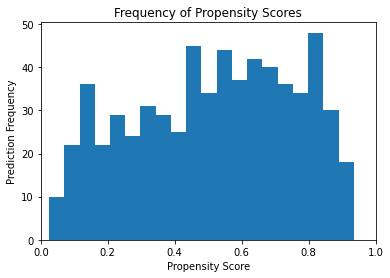

In [30]:
# Display Findings

print(f'Model AUC = {np.mean(aucs):.4g}')
print(f'Model R\u00b2 = {np.mean(r2s):.4g}')

plt.figure()
plt.hist(propensity_scores, bins=20)
plt.xlim([0,1])
plt.xlabel('Propensity Score')
plt.ylabel('Prediction Frequency')
plt.title('Frequency of Propensity Scores')
plt.show()

In [ ]:
Model AUC = 0.5519
Model R² = -10.7